In [87]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy
from control import lqr
from single_photons.estimators.kalman import KalmanFilter
import single_photons.utils.constants as ct
from single_photons.environment import Particle

In [248]:
T = 293
p = 1e-6
R = 147e-9
rho = 2200
index_refraction = 1.4440
tweezer_wavelength = 1.55e-6
tweezer_power = 200e-3
tweezer_waist = 0.6e-6
cavity_waist = 100e-6
cavity_length = 50e-3
eta_detec = 0.178

In [249]:
m_p = 4 / 3 * np.pi * R**3 * rho
v_gas = np.sqrt(3 * ct.kb * T / ct.m_gas)
Nm = rho/(ct.amu*60.08) #SiO2 molecular density
tweezer_freq = 2 * np.pi * ct.c / tweezer_wavelength
gamma = 15.8 * R**2 * p / (m_p * v_gas)
omega = (
    np.sqrt(12 / np.pi)
    * np.sqrt((index_refraction**2 - 1) / (index_refraction**2 + 2)) ** 3
    * np.sqrt(tweezer_power)
    / (tweezer_waist**2 * np.sqrt(rho * ct.c))
)


# Creio que dá para reduzir esse valor de forma que tratasse ele inversamente proporcional ao eta
# logo 6.68e-42 está para 0.178
# o que K_novo está para eta_novo

coupling = 6.68e-42 

period = 2 * np.pi / omega 
delta_t = 1e-9
control_step = 32 # defined as int, number of time steps of simulation necessary to compute the control policy
t = np.arange(0, 30 * period, delta_t)
N = t.shape[0]

In [250]:
env = Particle(omega, gamma, coupling, eta_detection=eta_detec, T=T)

In [251]:
variance_process = float(env.thermal_force_std**2 + env.backaction_std**2)
std_detection = np.sqrt(5.4e-21)/(env.zp_x)
std_detection, variance_process

(35.02814170059426, 150286.73477987695)

In [252]:
env.thermal_force_std

131.94083069716746

In [255]:
Q = np.array([[0, 0], [0, variance_process]])
R = np.array([[np.power(std_detection,2)]])

In [422]:
Ad = scipy.linalg.expm(env.A *control_step*delta_t)
cost_states = np.array([[delta_t*omega/2, 0],
                        [0, delta_t*omega/2]])
(G, S, E) = lqr(Ad, env.B*delta_t*control_step, cost_states, 1)

x0 = 100
P0 = 100*np.matrix(np.eye(2))
estimation = np.matrix([[x0*np.random.normal()], [x0*np.random.normal()]])
states = np.array([[x0*np.random.normal()], [x0*np.random.normal()]])
print(G)

[[9735733.44937443 2480057.36364347]]


In [405]:
new_states = np.zeros((N, 2))
measured_states = np.zeros((N))
estimated_states = np.zeros((N, 2))
estimated_states[0, :] = estimation.reshape((2))
estimation = estimation.reshape((2, 1))
control = np.array([[0]])
controls = []
kalman = KalmanFilter(estimation, P0, Ad, env.B * delta_t * control_step, env.C, Q * delta_t * control_step, R)
for i in tqdm(range(t.shape[0])):
    new_states[i, :] = states[:, 0]
    if not i % control_step:
        measured_states[i] = states[0, 0] + std_detection * np.random.normal()
        kalman.propagate_dynamics(control)
        kalman.compute_aposteriori(measured_states[i])
        estimated_states[i, :] = kalman.estimates_aposteriori[int(i/control_step)][:, 0].reshape((2))
        estimation = estimated_states[i, :].reshape((2, 1))
        control = -0.05*np.matmul(G, estimation)#+10000000*np.random.normal()
    else:
        measured_states[i] = measured_states[i-1]
        estimated_states[i, :] = estimated_states[i-1,:]
    controls.append(float(control))
    states = env.step(states, control=control, delta_t=delta_t)

100%|███████████████████████████████████████████████████████████████████████| 460552/460552 [00:30<00:00, 15041.95it/s]


In [406]:
cov_mat = kalman.error_covariance_aposteriori[-1]
z_std = env.zp_x*np.sqrt(cov_mat[0,0])
p_std = env.zp_p*np.sqrt(cov_mat[1,1])
cov_mat

matrix([[2.41988035, 0.18237037],
        [0.18237037, 2.45217762]])

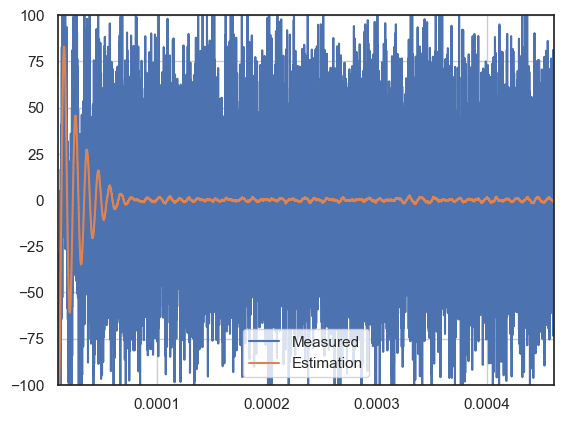

In [407]:
plt.plot(t[:], measured_states[:])
plt.plot(t[:], estimated_states[:,0])
plt.ylim([-100, 100])
plt.xlim([t[10000], t.max()])
plt.legend(['Measured', 'Estimation'])
plt.grid()

In [408]:
cov_mat = kalman.error_covariance_aposteriori[-1]
z_std = env.zp_x*np.sqrt(cov_mat[0,0])
p_std = env.zp_p*np.sqrt(cov_mat[1,1])
np.sqrt(cov_mat),-np.matmul(G, estimation)

(matrix([[1.55559646, 0.42704845],
         [0.42704845, 1.56594305]]),
 array([[9296420.35402502]]))

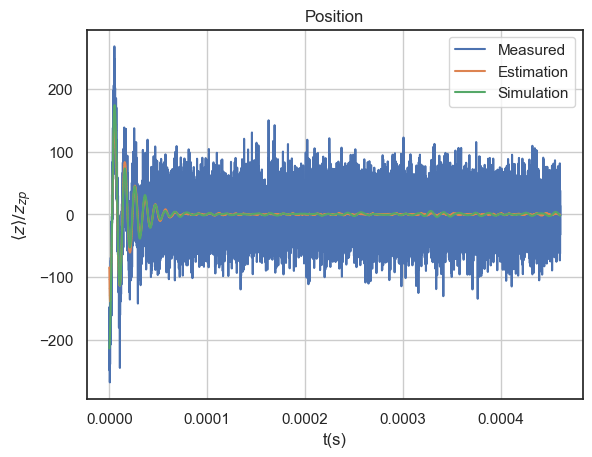

In [409]:
fig = plt.Figure()
plt.title('Position')
plt.plot(t, measured_states)
plt.plot(t[100:], estimated_states[100:,0])
plt.plot(t[100:], new_states[100:,0])
plt.legend(['Measured', 'Estimation', 'Simulation'], loc='upper right')
plt.xlabel(r't(s)')
plt.ylabel(r'$\langle z\rangle/z_{zp}$')
plt.grid()
plt.show()

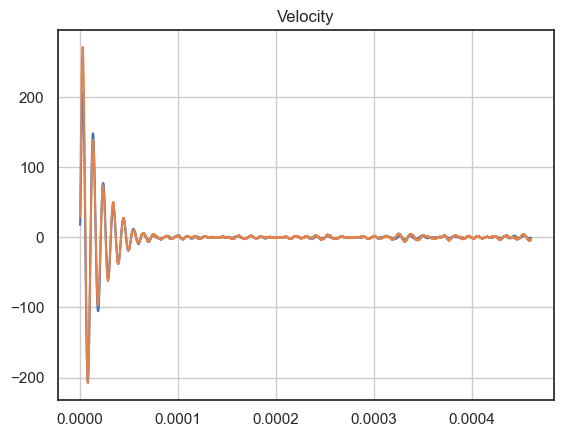

In [410]:
fig = plt.Figure()
plt.title('Velocity')
plt.plot(t[:], estimated_states[:,1])
plt.plot(t[:], new_states[:,1])
plt.grid()
plt.show()

In [411]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [412]:
df = pd.DataFrame()
df['z'] = butter_bandpass_filter(estimated_states[:,0][::30], 22e3, 220e3, 1/(30e-9), order=2)[500:]
df['p'] = butter_bandpass_filter(estimated_states[:,1][::30], 22e3, 220e3, 1/(30e-9), order=2)[500:]

(52.615626158806236, 119.59864740397268)

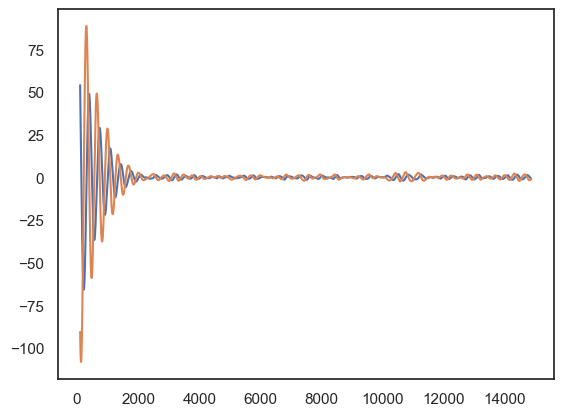

In [413]:
plt.plot(df['z'][100:])
plt.plot(df['p'][100:])
df['z'].values[0], df['p'].values[0]

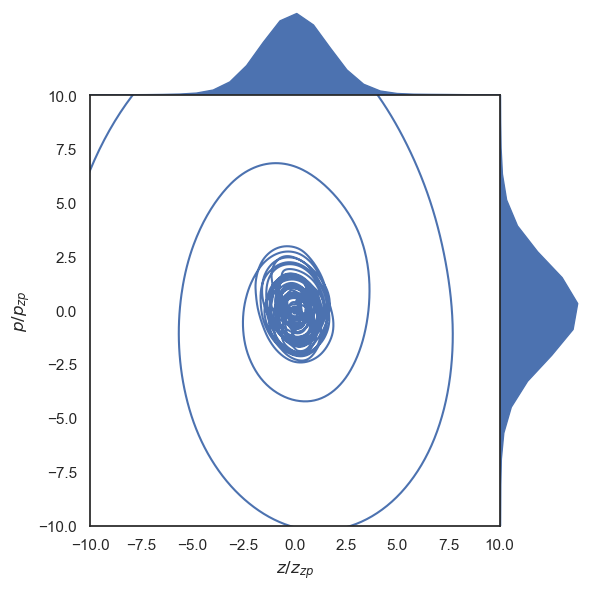

In [414]:
sns.set_theme(style="white")
g = sns.JointGrid(data=df, x="z", y="p", space=0, xlim=[-10,10], ylim=[-10,10])
g.plot_joint(sns.lineplot, sort = False)#clip=((2200, 6800), (10, 25)),
             #thresh=0, levels=100, cmap="rocket")
g.plot_marginals(sns.kdeplot, alpha=1, fill=True)
g.set_axis_labels(r'$z/z_{zp}$',r'$p/p_{zp}$')

In [415]:
(1/np.sqrt(delta_t))*1.76*np.sqrt(4e-28)/env.zp_x

530.5946680906476

In [416]:
cov_mat = kalman.error_covariance_aposteriori[-1]
z_std = env.zp_x*np.sqrt(cov_mat[0,0])
p_std = env.zp_p*np.sqrt(cov_mat[1,1])
np.sqrt(cov_mat)

matrix([[1.55559646, 0.42704845],
        [0.42704845, 1.56594305]])

In [417]:
estimated_states[-30:].var(axis=0)

array([0.0009938 , 0.00021414])

In [418]:
(env._m_*np.power(env.__omega__, 2)*np.power(z_std,2)+np.power(p_std,2)/env._m_)/(2*ct.hbar*env.__omega__)

1.2180144935641593

In [419]:
z_std*p_std > ct.hbar/2

True